# Pixel Localization with CNN

## Problem Description
In this project, we aim to build a Convolutional Neural Network (CNN) that predicts the exact (x, y) coordinate of a single white pixel (value 255) placed on a black 50x50 image. This is a regression problem where the model learns to infer the spatial position of a visual cue.


## Installation & Dependencies

In [6]:
# === Import Required Libraries ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Set Random Seed for Reproducibility ===
np.random.seed(42)
torch.manual_seed(42)


## Dataset Generation

The dataset is designed to predict the (x, y) coordinates of a white pixel placed in a black 50x50 image.

- **Data Generation**: The white pixel is placed at all possible positions in the grid (from (0,0) to (49,49)), resulting in 2500 unique images. Each image is normalized to a range of [0, 1], and the target coordinates (x, y) are also scaled similarly.
  
- **No Data Leakage**: The dataset is split into training, validation, and test sets (70%, 15%, 15%). There is no overlap between the sets, ensuring that the model doesn't "cheat" by seeing validation or test data during training.

- **Balanced Distribution**: The white pixel is evenly distributed across all positions in the grid, ensuring the model learns to predict any (x, y) location without any bias toward specific areas of the image.
This setup avoids data leakage and ensures the model generalizes well across the entire image.

- **Normalization**:The pixel values are normalized to the range [0, 1] by dividing by 255. This ensures that the model receives values in a consistent range that is easier to process during training.Similarly, the target coordinates [x, y] are normalized by dividing by the maximum value of the coordinate (49 in this case), scaling the target coordinates into the range [0, 1]. This helps in smoother optimization and avoids large gradient values during training.



In [3]:
# === Function to Generate Dataset ===
def generate_full_dataset(image_size=50):
    """
    Generates a dataset of images with one white pixel (value 255)
    at every possible (x, y) location in a grayscale image.

    Args:
        image_size (int): Height/width of square image (default: 50)

    Returns:
        torch.Tensor: Images of shape (N, 1, H, W)
        torch.Tensor: Corresponding normalized (x, y) coordinates
    """
    X, Y = [], []
    for x in range(image_size):
        for y in range(image_size):
            img = np.zeros((image_size, image_size), dtype=np.uint8)
            img[y, x] = 255  # Set one white pixel
            X.append(img / 255.0)  # Normalize to 0-1
            Y.append([x / 49.0, y / 49.0])  # Normalize coordinates to [0, 1]

    X = np.array(X).reshape(-1, 1, image_size, image_size).astype(np.float32)
    Y = np.array(Y).astype(np.float32)

    return torch.tensor(X), torch.tensor(Y)

# === Generate Dataset ===
X, Y = generate_full_dataset(image_size=50)


## 🧩 Data Splitting & Visualization -Distribution of training,validation and test

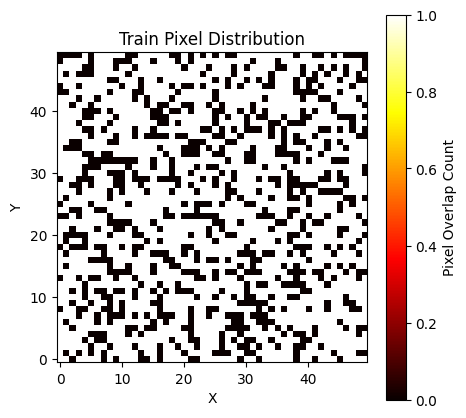

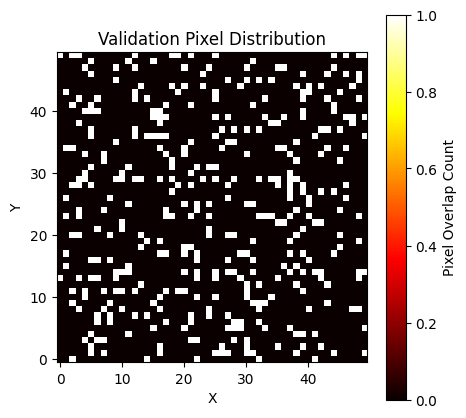

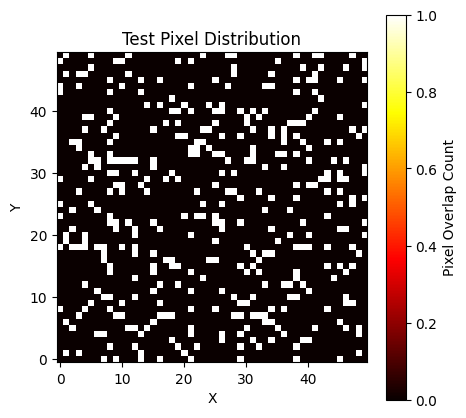

In [4]:
# === Split the Data ===
# First, split the dataset into training and temporary (val + test)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

# Then split the temp into validation and test sets
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42
)

# === Create TensorDatasets ===
train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
test_ds = TensorDataset(X_test, Y_test)

# === Create DataLoaders ===
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

# === Pixel Distribution Visualization Function ===
def plot_pixel_distribution(X_tensor, title):
    """
    Plots a heatmap showing the distribution of white pixels
    in the dataset.

    Args:
        X_tensor (torch.Tensor): Dataset tensor of shape (N, 1, H, W)
        title (str): Title for the heatmap plot
    """
    heatmap = torch.sum(X_tensor, dim=0).squeeze().numpy()

    plt.figure(figsize=(5, 5))
    plt.imshow(heatmap, cmap='hot')
    plt.title(title)
    plt.colorbar(label='Pixel Overlap Count')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.show()

# === Plot Pixel Distributions ===
plot_pixel_distribution(X_train, "Train Pixel Distribution")
plot_pixel_distribution(X_val, "Validation Pixel Distribution")
plot_pixel_distribution(X_test, "Test Pixel Distribution")


## 🏗️ Model Architecture

In [9]:
import torch.nn as nn
import torch

# === Define the CNN Model for Pixel Coordinate Regression ===
class PixelRegressor(nn.Module):
    """
    A simple CNN that takes a 50x50 grayscale image with a single white pixel
    and predicts its (x, y) coordinates as normalized values.
    """
    def __init__(self):
        super(PixelRegressor, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),

            nn.Linear(in_features=32 * 11 * 11, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(in_features=64, out_features=2)
        )

    def forward(self, x):
        return self.net(x)

# === Device Configuration ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Instantiate and Move Model to Device ===
model = PixelRegressor().to(device)

# === Print Model Summary ===

summary(model, input_size=(1, 50, 50))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             160
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 22, 22]           4,640
              ReLU-5           [-1, 32, 22, 22]               0
         MaxPool2d-6           [-1, 32, 11, 11]               0
           Flatten-7                 [-1, 3872]               0
            Linear-8                   [-1, 64]         247,872
              ReLU-9                   [-1, 64]               0
          Dropout-10                   [-1, 64]               0
           Linear-11                    [-1, 2]             130
Total params: 252,802
Trainable params: 252,802
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

## 🏃 Training the Model

In [11]:
# === Training Configuration ===
criterion = nn.MSELoss()                          # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stop_patience = 20                          # Number of epochs with no improvement before stopping

# === Training Function ===
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=300):
    """
    Train the CNN model with early stopping and return training and validation losses.

    Args:
        model (nn.Module): The neural network to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        epochs (int): Maximum number of training epochs.

    Returns:
        tuple: Lists of training and validation losses for each epoch.
    """
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * X_batch.size(0)

        train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # === Validation Phase ===
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                epoch_val_loss += loss.item() * X_batch.size(0)

        val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.5f}, Val Loss = {val_loss:.5f}")

        # === Early Stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model weights
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses


# === Train the Model ===
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer
)

# === Plot Training & Validation Loss Curve ===
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1: Train Loss = 0.01056, Val Loss = 0.00404
Epoch 2: Train Loss = 0.00836, Val Loss = 0.00511
Epoch 3: Train Loss = 0.00823, Val Loss = 0.00477
Epoch 4: Train Loss = 0.00714, Val Loss = 0.00300
Epoch 5: Train Loss = 0.00679, Val Loss = 0.00259
Epoch 6: Train Loss = 0.00744, Val Loss = 0.00449
Epoch 7: Train Loss = 0.00690, Val Loss = 0.00220
Epoch 8: Train Loss = 0.00671, Val Loss = 0.00327


KeyboardInterrupt: 

## 📊 Evaluation & Visualization

Test MSE: 0.00226, MAE: 0.03239, R² Score: 0.97365


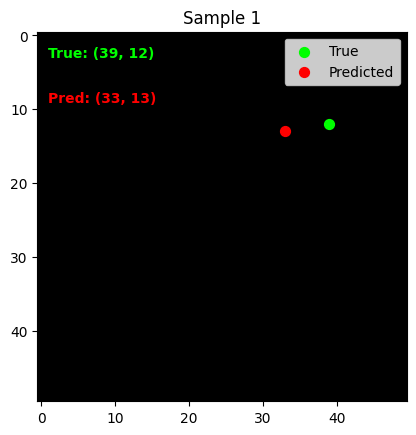

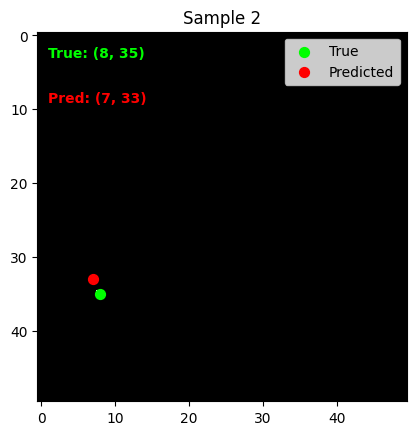

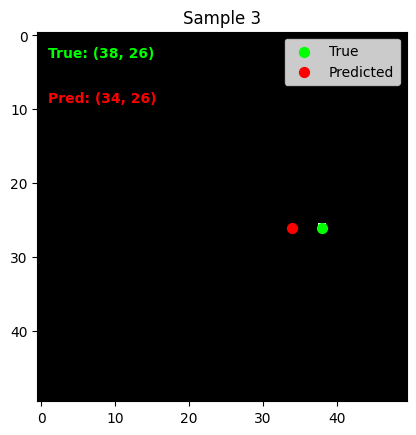

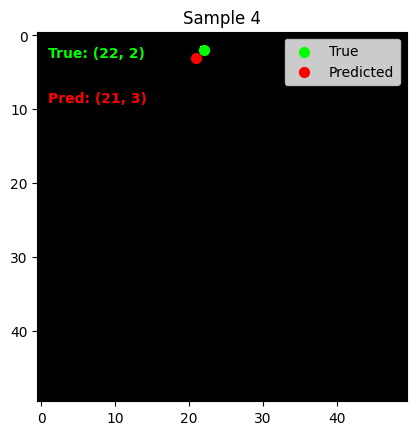

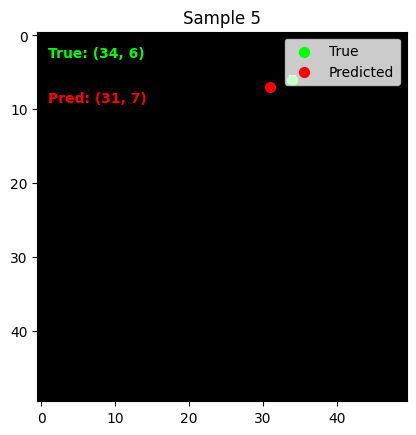

In [12]:
# === Load Best Model ===
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# === Evaluation Function ===
def evaluate_model(model, loader):
    """
    Evaluate the model on a given dataset loader.

    Args:
        model (nn.Module): Trained model.
        loader (DataLoader): DataLoader for evaluation.

    Returns:
        Tuple: (MSE, MAE, R², Ground Truths, Predictions)
    """
    model.eval()
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu()
            predictions.append(outputs)
            ground_truths.append(y_batch)

    y_pred = torch.cat(predictions).numpy()
    y_true = torch.cat(ground_truths).numpy()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mse, mae, r2, y_true, y_pred

# === Evaluate on Test Set ===
mse, mae, r2, Y_true_np, Y_pred_np = evaluate_model(model, test_loader)
print(f"Test MSE: {mse:.5f}, MAE: {mae:.5f}, R² Score: {r2:.5f}")


## Prediction Visualization Function

In [ ]:
# === Visualize Predictions ===
def show_predictions(X, Y_true, Y_pred, num_samples=5):
    """
    Display image samples with predicted and true coordinates.

    Args:
        X (Tensor): Input image data.
        Y_true (ndarray): True coordinates.
        Y_pred (ndarray): Predicted coordinates.
        num_samples (int): Number of samples to visualize.
    """
    for i in range(num_samples):
        img = X[i].squeeze().numpy()

        # Scale back from normalized [0,1] to [0,49] and convert to int
        pred_x, pred_y = (Y_pred[i] * 49).astype(int)
        true_x, true_y = (Y_true[i] * 49).astype(int)

        plt.imshow(img, cmap='gray')
        plt.scatter(true_x, true_y, color='lime', label='True', s=50)
        plt.scatter(pred_x, pred_y, color='red', label='Predicted', s=50)

        # Annotate values on the image
        plt.text(1, 3, f'True: ({true_x}, {true_y})', color='lime', fontsize=10, weight='bold')
        plt.text(1, 9, f'Pred: ({pred_x}, {pred_y})', color='red', fontsize=10, weight='bold')

        plt.title(f"Sample {i+1}")
        plt.legend(loc='upper right')
        plt.grid(False)
        plt.show()

# === Show Predictions ===
show_predictions(X_test, Y_true_np, Y_pred_np)


##  Conclusion

In this project, we trained a CNN model to accurately predict the position of a single white pixel in a black 50x50 image. We treated this as a regression task by outputting normalized (x, y) coordinates. Results show very low MSE and high R² scores, indicating the model learned the spatial localization effectively.


